In [1]:
import boto3
import botocore
import functools
from IPython.core.display import display, HTML
from iterdub import iterdub as ib
from iterpop import iterpop as ip
import itertools as it
import json
import matplotlib
import matplotlib.pyplot as plt
import math
import numpy as np
import pandas as pd
from pandas.util import hash_pandas_object
import seaborn as sns
from teeplot import teeplot as tp

In [2]:
from dishpylib.pyanalysis import calc_loglikelihoods_by_num_sets
from dishpylib.pyanalysis import count_hands_with_k_or_more_sets
from dishpylib.pyanalysis import count_hands_without_k_or_more_sets
from dishpylib.pyanalysis import estimate_interpolation_complexity
from dishpylib.pyanalysis import calc_loglikelihoods_over_set_sizes
from dishpylib.pyhelpers import get_control_t_distns
from dishpylib.pyhelpers import get_env_context
from dishpylib.pyhelpers import get_git_revision_hash
from dishpylib.pyhelpers import make_timestamp
from dishpylib.pyhelpers import NumpyEncoder
from dishpylib.pyhelpers import preprocess_competition_fitnesses
from dishpylib.pyhelpers import print_runtime

In [3]:
print_runtime()

context: ci
hostname: 879fd5d404ff
interpreter: 3.8.15 (default, Oct 12 2022, 19:14:39)  [GCC 7.5.0]
revision: cde679bf0
timestamp: 2022-11-08T09:19:32Z00:00

IPython==7.16.1
boto3==1.14.44
botocore==1.17.44
iterdub==0.2.0
iterpop==0.3.4
json==2.0.9
matplotlib==3.5.2
matplotlib==3.5.2
numpy==1.19.5
pandas==1.1.2
seaborn==0.11.2
teeplot==0.1.1


# get control data

In [4]:
control_fits_df = get_control_t_distns('prq49', 16, 40)

# get data

In [5]:
s3_handle = boto3.resource(
    's3',
    region_name="us-east-2",
    config=botocore.config.Config(
        signature_version=botocore.UNSIGNED,
    ),
)
bucket_handle = s3_handle.Bucket('prq49')

series_profiles, = bucket_handle.objects.filter(
    Prefix=f'endeavor=16/noncritical-phenotypeneutral-nopinterpolation-competitions/stage=6+what=collated/stint=40',
)

In [6]:
df = pd.read_csv(
    f's3://prq49/{series_profiles.key}',
    compression='xz',
)
dfdigest = '{:x}'.format( hash_pandas_object( df ).sum() )
dfdigest

'-7517923449d93617'

# preprocess data

In [7]:
df = preprocess_competition_fitnesses(df, control_fits_df)

# summarize data and model fitting

In [8]:
def log_lineplot(*args, **kwargs):
    sns.lineplot(*args, **kwargs)
    plt.yscale('log')
    plt.autoscale()

def lineplot_scatterplot(*args, **kwargs):
    sns.lineplot(
        *args,
        **{k : v for k, v in kwargs.items() if k != 'hue'},
        color='gray',
        zorder=1,
    )
    sns.scatterplot(
        *args,
        **kwargs,
        palette={
            'Significantly Advantageous' : sns.color_palette()[2],
            'Neutral' : sns.color_palette()[0],
            'Significantly Deleterious' : sns.color_palette()[1],
        },
        zorder=2,
    )
    plt.legend(
        handles=[
            matplotlib.patches.Patch(
                color=sns.color_palette()[2],
                label='Significantly Advantageous',
            ),
            matplotlib.patches.Patch(
                color=sns.color_palette()[0],
                label='Neutral',
            ),
            matplotlib.patches.Patch(
                color=sns.color_palette()[1],
                label='Significantly Deleterious',
            ),
        ],
    )


teeplots/bucket=prq49+endeavor=16+hue=relative-fitness+transform=filter-Stint-40+viz=lineplot-scatterplot+x=genome-nop-interpolation-num-nopped+y=fitness-differential+ext=.pdf
teeplots/bucket=prq49+endeavor=16+hue=relative-fitness+transform=filter-Stint-40+viz=lineplot-scatterplot+x=genome-nop-interpolation-num-nopped+y=fitness-differential+ext=.png


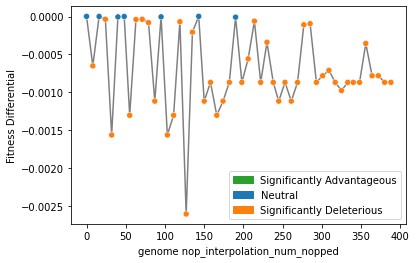

teeplots/bucket=prq49+endeavor=16+hue=set-size+transform=filter-Stint-40+viz=log-lineplot+x=num-sets+y=likelihood+ext=.pdf
teeplots/bucket=prq49+endeavor=16+hue=set-size+transform=filter-Stint-40+viz=log-lineplot+x=num-sets+y=likelihood+ext=.png


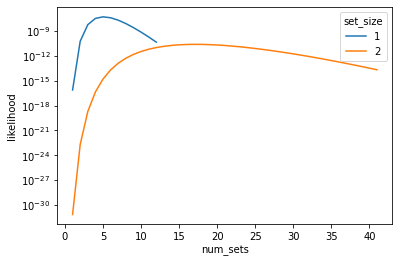

{
    "Series": 16000,
    "a=credible_interval_lower_bound_idx+set_size=1": 3,
    "a=credible_interval_lower_bound_idx+set_size=2": 10,
    "a=credible_interval_upper_bound_idx+set_size=1": 8,
    "a=credible_interval_upper_bound_idx+set_size=2": 27,
    "a=most_credible_idx+set_size=1": 5,
    "a=most_credible_idx+set_size=2": 17,
    "a=most_credible_likelihood+set_size=1": 4.950386356642954e-08,
    "a=most_credible_likelihood+set_size=2": 2.3901241491221503e-11,
    "all_nopped_is_less_fit": true,
    "credible_interval_lower_bound_idx": 3,
    "credible_interval_upper_bound_idx": 8,
    "interpolation_complexity": 5,
    "most_credible_idx": 5,
    "most_credible_likelihood": 4.950386356642954e-08,
    "most_credible_set_size": 1,
    "none_nopped_is_less_fit": false
}


teeplots/bucket=prq49+endeavor=16+hue=relative-fitness+transform=filter-Stint-40+viz=lineplot-scatterplot+x=genome-nop-interpolation-num-nopped+y=fitness-differential+ext=.pdf
teeplots/bucket=prq49+endeavor=16+hue=relative-fitness+transform=filter-Stint-40+viz=lineplot-scatterplot+x=genome-nop-interpolation-num-nopped+y=fitness-differential+ext=.png


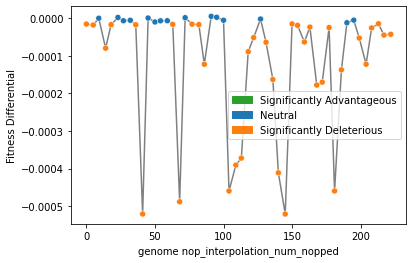

teeplots/bucket=prq49+endeavor=16+hue=set-size+transform=filter-Stint-40+viz=log-lineplot+x=num-sets+y=likelihood+ext=.pdf
teeplots/bucket=prq49+endeavor=16+hue=set-size+transform=filter-Stint-40+viz=log-lineplot+x=num-sets+y=likelihood+ext=.png


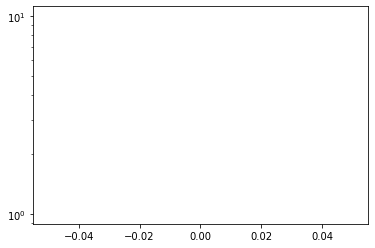

{
    "Series": 16001,
    "all_nopped_is_less_fit": true,
    "credible_interval_lower_bound_idx": NaN,
    "credible_interval_upper_bound_idx": NaN,
    "interpolation_complexity": NaN,
    "most_credible_idx": NaN,
    "most_credible_likelihood": NaN,
    "most_credible_set_size": NaN,
    "none_nopped_is_less_fit": true
}


teeplots/bucket=prq49+endeavor=16+hue=relative-fitness+transform=filter-Stint-40+viz=lineplot-scatterplot+x=genome-nop-interpolation-num-nopped+y=fitness-differential+ext=.pdf
teeplots/bucket=prq49+endeavor=16+hue=relative-fitness+transform=filter-Stint-40+viz=lineplot-scatterplot+x=genome-nop-interpolation-num-nopped+y=fitness-differential+ext=.png


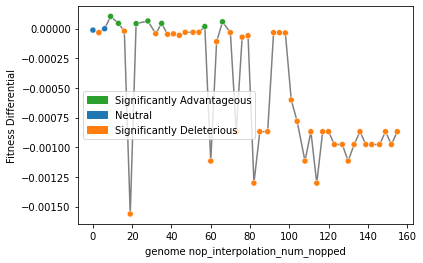

teeplots/bucket=prq49+endeavor=16+hue=set-size+transform=filter-Stint-40+viz=log-lineplot+x=num-sets+y=likelihood+ext=.pdf
teeplots/bucket=prq49+endeavor=16+hue=set-size+transform=filter-Stint-40+viz=log-lineplot+x=num-sets+y=likelihood+ext=.png


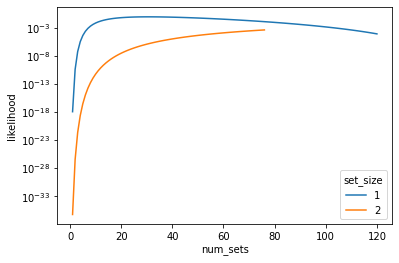

{
    "Series": 16002,
    "a=credible_interval_lower_bound_idx+set_size=1": 12,
    "a=credible_interval_lower_bound_idx+set_size=2": 49,
    "a=credible_interval_upper_bound_idx+set_size=1": 75,
    "a=credible_interval_upper_bound_idx+set_size=2": 76,
    "a=most_credible_idx+set_size=1": 31,
    "a=most_credible_idx+set_size=2": 76,
    "a=most_credible_likelihood+set_size=1": 0.1002070498342817,
    "a=most_credible_likelihood+set_size=2": 0.0004650663871172073,
    "all_nopped_is_less_fit": true,
    "credible_interval_lower_bound_idx": 12,
    "credible_interval_upper_bound_idx": 75,
    "interpolation_complexity": 31,
    "most_credible_idx": 31,
    "most_credible_likelihood": 0.1002070498342817,
    "most_credible_set_size": 1,
    "none_nopped_is_less_fit": false
}


teeplots/bucket=prq49+endeavor=16+hue=relative-fitness+transform=filter-Stint-40+viz=lineplot-scatterplot+x=genome-nop-interpolation-num-nopped+y=fitness-differential+ext=.pdf
teeplots/bucket=prq49+endeavor=16+hue=relative-fitness+transform=filter-Stint-40+viz=lineplot-scatterplot+x=genome-nop-interpolation-num-nopped+y=fitness-differential+ext=.png


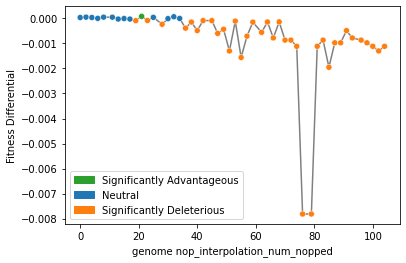

teeplots/bucket=prq49+endeavor=16+hue=set-size+transform=filter-Stint-40+viz=log-lineplot+x=num-sets+y=likelihood+ext=.pdf
teeplots/bucket=prq49+endeavor=16+hue=set-size+transform=filter-Stint-40+viz=log-lineplot+x=num-sets+y=likelihood+ext=.png


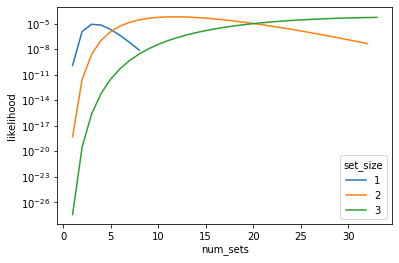

{
    "Series": 16003,
    "a=credible_interval_lower_bound_idx+set_size=1": 2,
    "a=credible_interval_lower_bound_idx+set_size=2": 7,
    "a=credible_interval_lower_bound_idx+set_size=3": 20,
    "a=credible_interval_upper_bound_idx+set_size=1": 5,
    "a=credible_interval_upper_bound_idx+set_size=2": 20,
    "a=credible_interval_upper_bound_idx+set_size=3": 33,
    "a=most_credible_idx+set_size=1": 3,
    "a=most_credible_idx+set_size=2": 12,
    "a=most_credible_idx+set_size=3": 33,
    "a=most_credible_likelihood+set_size=1": 8.526558866761699e-06,
    "a=most_credible_likelihood+set_size=2": 6.352772984969724e-05,
    "a=most_credible_likelihood+set_size=3": 5.505593887485353e-05,
    "all_nopped_is_less_fit": true,
    "credible_interval_lower_bound_idx": 7,
    "credible_interval_upper_bound_idx": 20,
    "interpolation_complexity": 12,
    "most_credible_idx": 12,
    "most_credible_likelihood": 6.352772984969724e-05,
    "most_credible_set_size": 2,
    "none_nopped_is_less_

teeplots/bucket=prq49+endeavor=16+hue=relative-fitness+transform=filter-Stint-40+viz=lineplot-scatterplot+x=genome-nop-interpolation-num-nopped+y=fitness-differential+ext=.pdf
teeplots/bucket=prq49+endeavor=16+hue=relative-fitness+transform=filter-Stint-40+viz=lineplot-scatterplot+x=genome-nop-interpolation-num-nopped+y=fitness-differential+ext=.png


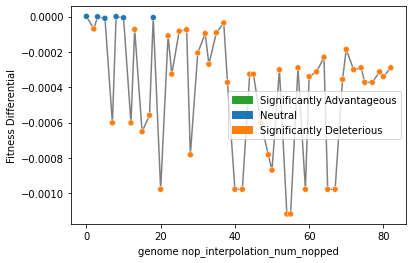

teeplots/bucket=prq49+endeavor=16+hue=set-size+transform=filter-Stint-40+viz=log-lineplot+x=num-sets+y=likelihood+ext=.pdf
teeplots/bucket=prq49+endeavor=16+hue=set-size+transform=filter-Stint-40+viz=log-lineplot+x=num-sets+y=likelihood+ext=.png


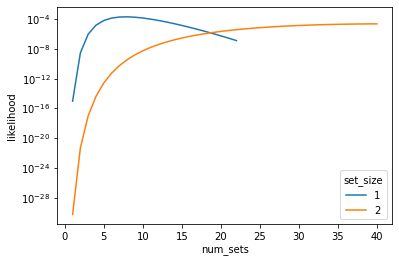

{
    "Series": 16004,
    "a=credible_interval_lower_bound_idx+set_size=1": 5,
    "a=credible_interval_lower_bound_idx+set_size=2": 23,
    "a=credible_interval_upper_bound_idx+set_size=1": 14,
    "a=credible_interval_upper_bound_idx+set_size=2": 40,
    "a=most_credible_idx+set_size=1": 8,
    "a=most_credible_idx+set_size=2": 40,
    "a=most_credible_likelihood+set_size=1": 0.00019251299394689185,
    "a=most_credible_likelihood+set_size=2": 2.204739580678035e-05,
    "all_nopped_is_less_fit": true,
    "credible_interval_lower_bound_idx": 5,
    "credible_interval_upper_bound_idx": 14,
    "interpolation_complexity": 8,
    "most_credible_idx": 8,
    "most_credible_likelihood": 0.00019251299394689185,
    "most_credible_set_size": 1,
    "none_nopped_is_less_fit": false
}


teeplots/bucket=prq49+endeavor=16+hue=relative-fitness+transform=filter-Stint-40+viz=lineplot-scatterplot+x=genome-nop-interpolation-num-nopped+y=fitness-differential+ext=.pdf
teeplots/bucket=prq49+endeavor=16+hue=relative-fitness+transform=filter-Stint-40+viz=lineplot-scatterplot+x=genome-nop-interpolation-num-nopped+y=fitness-differential+ext=.png


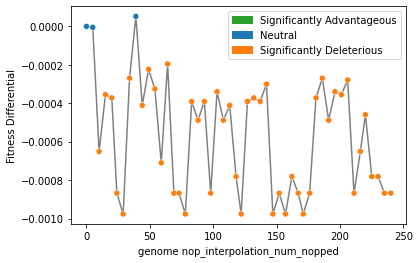

teeplots/bucket=prq49+endeavor=16+hue=set-size+transform=filter-Stint-40+viz=log-lineplot+x=num-sets+y=likelihood+ext=.pdf
teeplots/bucket=prq49+endeavor=16+hue=set-size+transform=filter-Stint-40+viz=log-lineplot+x=num-sets+y=likelihood+ext=.png


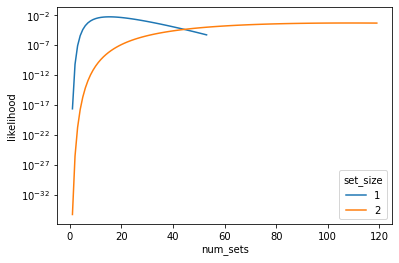

{
    "Series": 16005,
    "a=credible_interval_lower_bound_idx+set_size=1": 8,
    "a=credible_interval_lower_bound_idx+set_size=2": 57,
    "a=credible_interval_upper_bound_idx+set_size=1": 32,
    "a=credible_interval_upper_bound_idx+set_size=2": 119,
    "a=most_credible_idx+set_size=1": 15,
    "a=most_credible_idx+set_size=2": 109,
    "a=most_credible_likelihood+set_size=1": 0.0057722539655891214,
    "a=most_credible_likelihood+set_size=2": 0.0005367599304457939,
    "all_nopped_is_less_fit": true,
    "credible_interval_lower_bound_idx": 8,
    "credible_interval_upper_bound_idx": 32,
    "interpolation_complexity": 15,
    "most_credible_idx": 15,
    "most_credible_likelihood": 0.0057722539655891214,
    "most_credible_set_size": 1,
    "none_nopped_is_less_fit": false
}


teeplots/bucket=prq49+endeavor=16+hue=relative-fitness+transform=filter-Stint-40+viz=lineplot-scatterplot+x=genome-nop-interpolation-num-nopped+y=fitness-differential+ext=.pdf
teeplots/bucket=prq49+endeavor=16+hue=relative-fitness+transform=filter-Stint-40+viz=lineplot-scatterplot+x=genome-nop-interpolation-num-nopped+y=fitness-differential+ext=.png


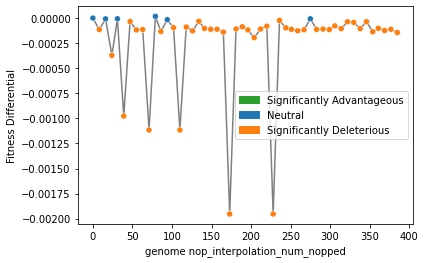

teeplots/bucket=prq49+endeavor=16+hue=set-size+transform=filter-Stint-40+viz=log-lineplot+x=num-sets+y=likelihood+ext=.pdf
teeplots/bucket=prq49+endeavor=16+hue=set-size+transform=filter-Stint-40+viz=log-lineplot+x=num-sets+y=likelihood+ext=.png


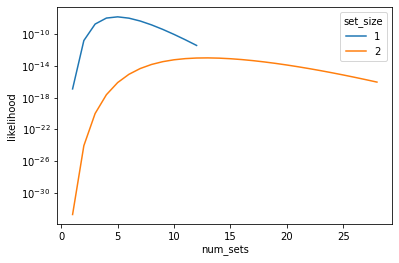

{
    "Series": 16006,
    "a=credible_interval_lower_bound_idx+set_size=1": 3,
    "a=credible_interval_lower_bound_idx+set_size=2": 8,
    "a=credible_interval_upper_bound_idx+set_size=1": 7,
    "a=credible_interval_upper_bound_idx+set_size=2": 19,
    "a=most_credible_idx+set_size=1": 5,
    "a=most_credible_idx+set_size=2": 13,
    "a=most_credible_likelihood+set_size=1": 1.3716985226667414e-08,
    "a=most_credible_likelihood+set_size=2": 9.489494061218198e-14,
    "all_nopped_is_less_fit": true,
    "credible_interval_lower_bound_idx": 3,
    "credible_interval_upper_bound_idx": 7,
    "interpolation_complexity": 5,
    "most_credible_idx": 5,
    "most_credible_likelihood": 1.3716985226667414e-08,
    "most_credible_set_size": 1,
    "none_nopped_is_less_fit": false
}


teeplots/bucket=prq49+endeavor=16+hue=relative-fitness+transform=filter-Stint-40+viz=lineplot-scatterplot+x=genome-nop-interpolation-num-nopped+y=fitness-differential+ext=.pdf
teeplots/bucket=prq49+endeavor=16+hue=relative-fitness+transform=filter-Stint-40+viz=lineplot-scatterplot+x=genome-nop-interpolation-num-nopped+y=fitness-differential+ext=.png


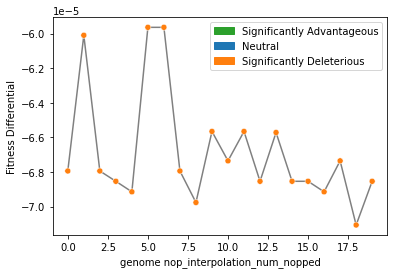

teeplots/bucket=prq49+endeavor=16+hue=set-size+transform=filter-Stint-40+viz=log-lineplot+x=num-sets+y=likelihood+ext=.pdf
teeplots/bucket=prq49+endeavor=16+hue=set-size+transform=filter-Stint-40+viz=log-lineplot+x=num-sets+y=likelihood+ext=.png


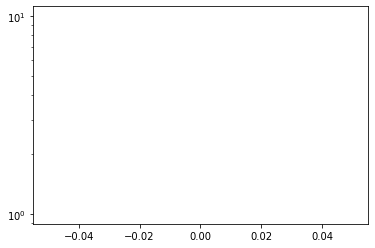

{
    "Series": 16007,
    "all_nopped_is_less_fit": true,
    "credible_interval_lower_bound_idx": NaN,
    "credible_interval_upper_bound_idx": NaN,
    "interpolation_complexity": NaN,
    "most_credible_idx": NaN,
    "most_credible_likelihood": NaN,
    "most_credible_set_size": NaN,
    "none_nopped_is_less_fit": true
}


teeplots/bucket=prq49+endeavor=16+hue=relative-fitness+transform=filter-Stint-40+viz=lineplot-scatterplot+x=genome-nop-interpolation-num-nopped+y=fitness-differential+ext=.pdf
teeplots/bucket=prq49+endeavor=16+hue=relative-fitness+transform=filter-Stint-40+viz=lineplot-scatterplot+x=genome-nop-interpolation-num-nopped+y=fitness-differential+ext=.png


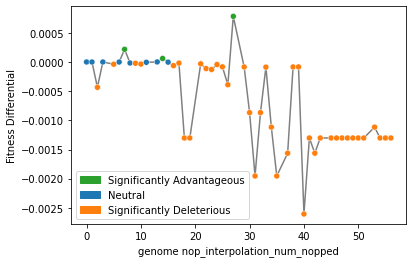

teeplots/bucket=prq49+endeavor=16+hue=set-size+transform=filter-Stint-40+viz=log-lineplot+x=num-sets+y=likelihood+ext=.pdf
teeplots/bucket=prq49+endeavor=16+hue=set-size+transform=filter-Stint-40+viz=log-lineplot+x=num-sets+y=likelihood+ext=.png


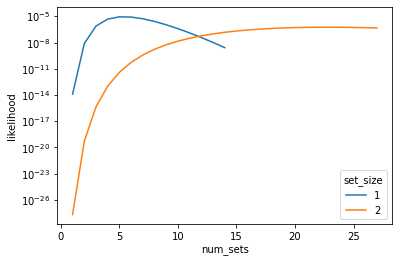

{
    "Series": 16008,
    "a=credible_interval_lower_bound_idx+set_size=1": 4,
    "a=credible_interval_lower_bound_idx+set_size=2": 14,
    "a=credible_interval_upper_bound_idx+set_size=1": 9,
    "a=credible_interval_upper_bound_idx+set_size=2": 27,
    "a=most_credible_idx+set_size=1": 5,
    "a=most_credible_idx+set_size=2": 23,
    "a=most_credible_likelihood+set_size=1": 8.796270582145311e-06,
    "a=most_credible_likelihood+set_size=2": 5.742347198863929e-07,
    "all_nopped_is_less_fit": true,
    "credible_interval_lower_bound_idx": 4,
    "credible_interval_upper_bound_idx": 9,
    "interpolation_complexity": 5,
    "most_credible_idx": 5,
    "most_credible_likelihood": 8.796270582145311e-06,
    "most_credible_set_size": 1,
    "none_nopped_is_less_fit": false
}


teeplots/bucket=prq49+endeavor=16+hue=relative-fitness+transform=filter-Stint-40+viz=lineplot-scatterplot+x=genome-nop-interpolation-num-nopped+y=fitness-differential+ext=.pdf
teeplots/bucket=prq49+endeavor=16+hue=relative-fitness+transform=filter-Stint-40+viz=lineplot-scatterplot+x=genome-nop-interpolation-num-nopped+y=fitness-differential+ext=.png


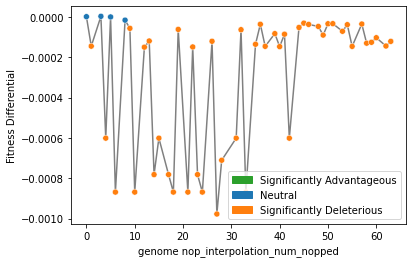

teeplots/bucket=prq49+endeavor=16+hue=set-size+transform=filter-Stint-40+viz=log-lineplot+x=num-sets+y=likelihood+ext=.pdf
teeplots/bucket=prq49+endeavor=16+hue=set-size+transform=filter-Stint-40+viz=log-lineplot+x=num-sets+y=likelihood+ext=.png


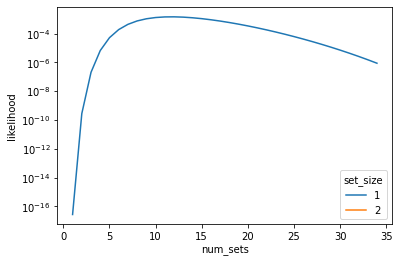

{
    "Series": 16009,
    "a=credible_interval_lower_bound_idx+set_size=1": 6,
    "a=credible_interval_lower_bound_idx+set_size=2": NaN,
    "a=credible_interval_upper_bound_idx+set_size=1": 21,
    "a=credible_interval_upper_bound_idx+set_size=2": NaN,
    "a=most_credible_idx+set_size=1": 12,
    "a=most_credible_idx+set_size=2": NaN,
    "a=most_credible_likelihood+set_size=1": 0.0014807180596583826,
    "a=most_credible_likelihood+set_size=2": NaN,
    "all_nopped_is_less_fit": true,
    "credible_interval_lower_bound_idx": 6,
    "credible_interval_upper_bound_idx": 21,
    "interpolation_complexity": 12,
    "most_credible_idx": 12,
    "most_credible_likelihood": 0.0014807180596583826,
    "most_credible_set_size": 1,
    "none_nopped_is_less_fit": false
}


teeplots/bucket=prq49+endeavor=16+hue=relative-fitness+transform=filter-Stint-40+viz=lineplot-scatterplot+x=genome-nop-interpolation-num-nopped+y=fitness-differential+ext=.pdf
teeplots/bucket=prq49+endeavor=16+hue=relative-fitness+transform=filter-Stint-40+viz=lineplot-scatterplot+x=genome-nop-interpolation-num-nopped+y=fitness-differential+ext=.png


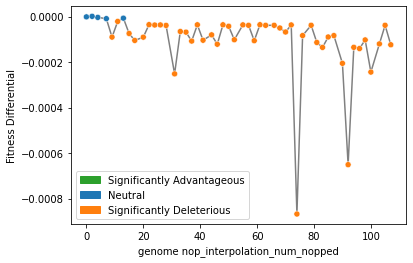

teeplots/bucket=prq49+endeavor=16+hue=set-size+transform=filter-Stint-40+viz=log-lineplot+x=num-sets+y=likelihood+ext=.pdf
teeplots/bucket=prq49+endeavor=16+hue=set-size+transform=filter-Stint-40+viz=log-lineplot+x=num-sets+y=likelihood+ext=.png


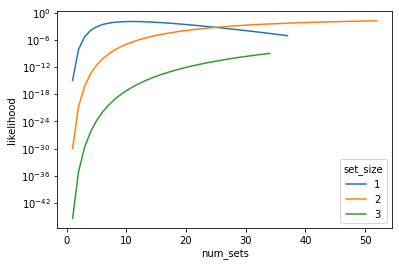

{
    "Series": 16010,
    "a=credible_interval_lower_bound_idx+set_size=1": 6,
    "a=credible_interval_lower_bound_idx+set_size=2": 31,
    "a=credible_interval_lower_bound_idx+set_size=3": 28,
    "a=credible_interval_upper_bound_idx+set_size=1": 22,
    "a=credible_interval_upper_bound_idx+set_size=2": 52,
    "a=credible_interval_upper_bound_idx+set_size=3": 34,
    "a=most_credible_idx+set_size=1": 11,
    "a=most_credible_idx+set_size=2": 52,
    "a=most_credible_idx+set_size=3": 34,
    "a=most_credible_likelihood+set_size=1": 0.012112559094452576,
    "a=most_credible_likelihood+set_size=2": 0.016940052282386917,
    "a=most_credible_likelihood+set_size=3": 1.0546014694064555e-09,
    "all_nopped_is_less_fit": true,
    "credible_interval_lower_bound_idx": 31,
    "credible_interval_upper_bound_idx": 52,
    "interpolation_complexity": 52,
    "most_credible_idx": 52,
    "most_credible_likelihood": 0.016940052282386917,
    "most_credible_set_size": 2,
    "none_nopped_is_les

teeplots/bucket=prq49+endeavor=16+hue=relative-fitness+transform=filter-Stint-40+viz=lineplot-scatterplot+x=genome-nop-interpolation-num-nopped+y=fitness-differential+ext=.pdf
teeplots/bucket=prq49+endeavor=16+hue=relative-fitness+transform=filter-Stint-40+viz=lineplot-scatterplot+x=genome-nop-interpolation-num-nopped+y=fitness-differential+ext=.png


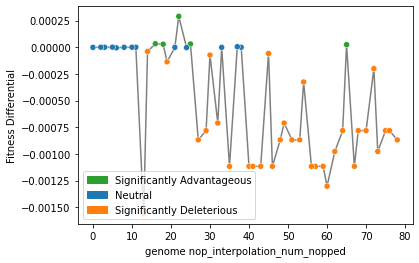

teeplots/bucket=prq49+endeavor=16+hue=set-size+transform=filter-Stint-40+viz=log-lineplot+x=num-sets+y=likelihood+ext=.pdf
teeplots/bucket=prq49+endeavor=16+hue=set-size+transform=filter-Stint-40+viz=log-lineplot+x=num-sets+y=likelihood+ext=.png


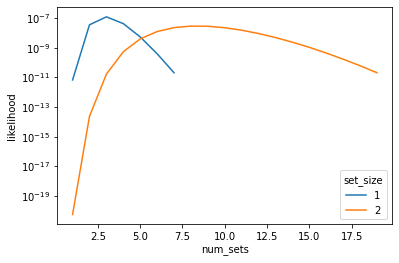

{
    "Series": 16011,
    "a=credible_interval_lower_bound_idx+set_size=1": 2,
    "a=credible_interval_lower_bound_idx+set_size=2": 5,
    "a=credible_interval_upper_bound_idx+set_size=1": 4,
    "a=credible_interval_upper_bound_idx+set_size=2": 13,
    "a=most_credible_idx+set_size=1": 3,
    "a=most_credible_idx+set_size=2": 8,
    "a=most_credible_likelihood+set_size=1": 1.2193618263344055e-07,
    "a=most_credible_likelihood+set_size=2": 2.886703902978332e-08,
    "all_nopped_is_less_fit": true,
    "credible_interval_lower_bound_idx": 2,
    "credible_interval_upper_bound_idx": 4,
    "interpolation_complexity": 3,
    "most_credible_idx": 3,
    "most_credible_likelihood": 1.2193618263344055e-07,
    "most_credible_set_size": 1,
    "none_nopped_is_less_fit": false
}


teeplots/bucket=prq49+endeavor=16+hue=relative-fitness+transform=filter-Stint-40+viz=lineplot-scatterplot+x=genome-nop-interpolation-num-nopped+y=fitness-differential+ext=.pdf
teeplots/bucket=prq49+endeavor=16+hue=relative-fitness+transform=filter-Stint-40+viz=lineplot-scatterplot+x=genome-nop-interpolation-num-nopped+y=fitness-differential+ext=.png


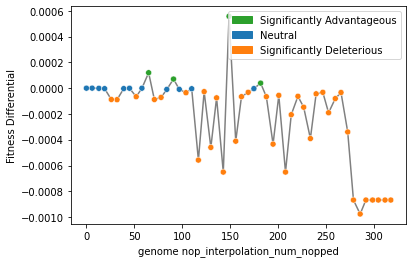

teeplots/bucket=prq49+endeavor=16+hue=set-size+transform=filter-Stint-40+viz=log-lineplot+x=num-sets+y=likelihood+ext=.pdf
teeplots/bucket=prq49+endeavor=16+hue=set-size+transform=filter-Stint-40+viz=log-lineplot+x=num-sets+y=likelihood+ext=.png


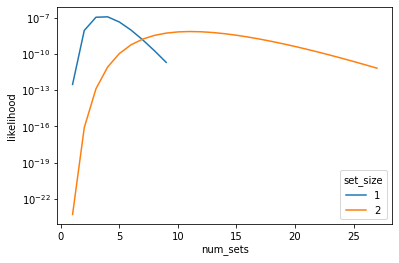

{
    "Series": 16012,
    "a=credible_interval_lower_bound_idx+set_size=1": 3,
    "a=credible_interval_lower_bound_idx+set_size=2": 7,
    "a=credible_interval_upper_bound_idx+set_size=1": 6,
    "a=credible_interval_upper_bound_idx+set_size=2": 18,
    "a=most_credible_idx+set_size=1": 4,
    "a=most_credible_idx+set_size=2": 11,
    "a=most_credible_likelihood+set_size=1": 1.1570799138546991e-07,
    "a=most_credible_likelihood+set_size=2": 7.0638695120520846e-09,
    "all_nopped_is_less_fit": true,
    "credible_interval_lower_bound_idx": 3,
    "credible_interval_upper_bound_idx": 6,
    "interpolation_complexity": 4,
    "most_credible_idx": 4,
    "most_credible_likelihood": 1.1570799138546991e-07,
    "most_credible_set_size": 1,
    "none_nopped_is_less_fit": false
}


teeplots/bucket=prq49+endeavor=16+hue=relative-fitness+transform=filter-Stint-40+viz=lineplot-scatterplot+x=genome-nop-interpolation-num-nopped+y=fitness-differential+ext=.pdf
teeplots/bucket=prq49+endeavor=16+hue=relative-fitness+transform=filter-Stint-40+viz=lineplot-scatterplot+x=genome-nop-interpolation-num-nopped+y=fitness-differential+ext=.png


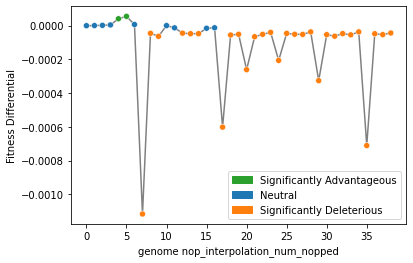

teeplots/bucket=prq49+endeavor=16+hue=set-size+transform=filter-Stint-40+viz=log-lineplot+x=num-sets+y=likelihood+ext=.pdf
teeplots/bucket=prq49+endeavor=16+hue=set-size+transform=filter-Stint-40+viz=log-lineplot+x=num-sets+y=likelihood+ext=.png


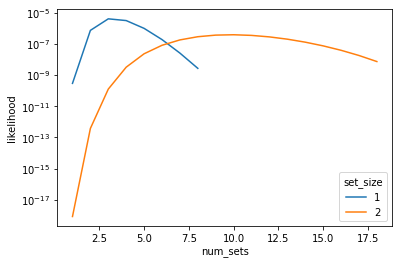

{
    "Series": 16013,
    "a=credible_interval_lower_bound_idx+set_size=1": 2,
    "a=credible_interval_lower_bound_idx+set_size=2": 6,
    "a=credible_interval_upper_bound_idx+set_size=1": 5,
    "a=credible_interval_upper_bound_idx+set_size=2": 15,
    "a=most_credible_idx+set_size=1": 3,
    "a=most_credible_idx+set_size=2": 10,
    "a=most_credible_likelihood+set_size=1": 3.973340949251909e-06,
    "a=most_credible_likelihood+set_size=2": 3.7990385226102734e-07,
    "all_nopped_is_less_fit": true,
    "credible_interval_lower_bound_idx": 2,
    "credible_interval_upper_bound_idx": 5,
    "interpolation_complexity": 3,
    "most_credible_idx": 3,
    "most_credible_likelihood": 3.973340949251909e-06,
    "most_credible_set_size": 1,
    "none_nopped_is_less_fit": false
}


teeplots/bucket=prq49+endeavor=16+hue=relative-fitness+transform=filter-Stint-40+viz=lineplot-scatterplot+x=genome-nop-interpolation-num-nopped+y=fitness-differential+ext=.pdf
teeplots/bucket=prq49+endeavor=16+hue=relative-fitness+transform=filter-Stint-40+viz=lineplot-scatterplot+x=genome-nop-interpolation-num-nopped+y=fitness-differential+ext=.png


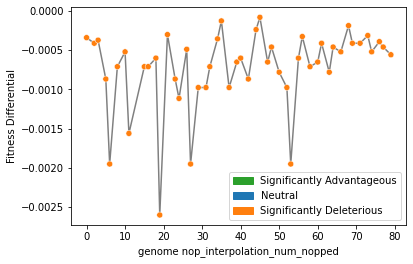

teeplots/bucket=prq49+endeavor=16+hue=set-size+transform=filter-Stint-40+viz=log-lineplot+x=num-sets+y=likelihood+ext=.pdf
teeplots/bucket=prq49+endeavor=16+hue=set-size+transform=filter-Stint-40+viz=log-lineplot+x=num-sets+y=likelihood+ext=.png


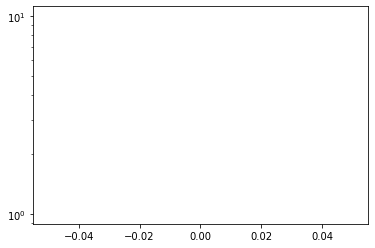

{
    "Series": 16014,
    "all_nopped_is_less_fit": true,
    "credible_interval_lower_bound_idx": NaN,
    "credible_interval_upper_bound_idx": NaN,
    "interpolation_complexity": NaN,
    "most_credible_idx": NaN,
    "most_credible_likelihood": NaN,
    "most_credible_set_size": NaN,
    "none_nopped_is_less_fit": true
}


teeplots/bucket=prq49+endeavor=16+hue=relative-fitness+transform=filter-Stint-40+viz=lineplot-scatterplot+x=genome-nop-interpolation-num-nopped+y=fitness-differential+ext=.pdf
teeplots/bucket=prq49+endeavor=16+hue=relative-fitness+transform=filter-Stint-40+viz=lineplot-scatterplot+x=genome-nop-interpolation-num-nopped+y=fitness-differential+ext=.png


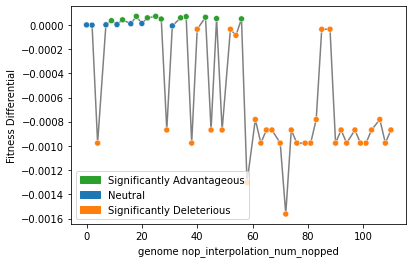

teeplots/bucket=prq49+endeavor=16+hue=set-size+transform=filter-Stint-40+viz=log-lineplot+x=num-sets+y=likelihood+ext=.pdf
teeplots/bucket=prq49+endeavor=16+hue=set-size+transform=filter-Stint-40+viz=log-lineplot+x=num-sets+y=likelihood+ext=.png


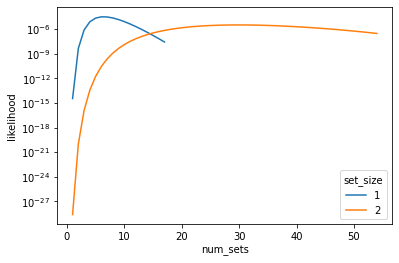

{
    "Series": 16015,
    "a=credible_interval_lower_bound_idx+set_size=1": 4,
    "a=credible_interval_lower_bound_idx+set_size=2": 17,
    "a=credible_interval_upper_bound_idx+set_size=1": 11,
    "a=credible_interval_upper_bound_idx+set_size=2": 49,
    "a=most_credible_idx+set_size=1": 6,
    "a=most_credible_idx+set_size=2": 30,
    "a=most_credible_likelihood+set_size=1": 3.163754533466081e-05,
    "a=most_credible_likelihood+set_size=2": 3.2598724375834873e-06,
    "all_nopped_is_less_fit": true,
    "credible_interval_lower_bound_idx": 4,
    "credible_interval_upper_bound_idx": 11,
    "interpolation_complexity": 6,
    "most_credible_idx": 6,
    "most_credible_likelihood": 3.163754533466081e-05,
    "most_credible_set_size": 1,
    "none_nopped_is_less_fit": false
}


teeplots/bucket=prq49+endeavor=16+hue=relative-fitness+transform=filter-Stint-40+viz=lineplot-scatterplot+x=genome-nop-interpolation-num-nopped+y=fitness-differential+ext=.pdf
teeplots/bucket=prq49+endeavor=16+hue=relative-fitness+transform=filter-Stint-40+viz=lineplot-scatterplot+x=genome-nop-interpolation-num-nopped+y=fitness-differential+ext=.png


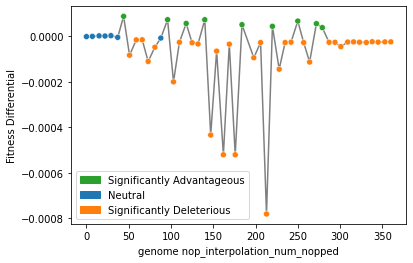

teeplots/bucket=prq49+endeavor=16+hue=set-size+transform=filter-Stint-40+viz=log-lineplot+x=num-sets+y=likelihood+ext=.pdf
teeplots/bucket=prq49+endeavor=16+hue=set-size+transform=filter-Stint-40+viz=log-lineplot+x=num-sets+y=likelihood+ext=.png


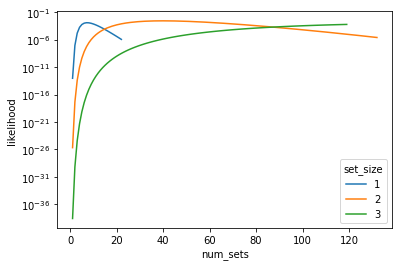

{
    "Series": 16016,
    "a=credible_interval_lower_bound_idx+set_size=1": 4,
    "a=credible_interval_lower_bound_idx+set_size=2": 19,
    "a=credible_interval_lower_bound_idx+set_size=3": 72,
    "a=credible_interval_upper_bound_idx+set_size=1": 13,
    "a=credible_interval_upper_bound_idx+set_size=2": 80,
    "a=credible_interval_upper_bound_idx+set_size=3": 119,
    "a=most_credible_idx+set_size=1": 7,
    "a=most_credible_idx+set_size=2": 40,
    "a=most_credible_idx+set_size=3": 119,
    "a=most_credible_likelihood+set_size=1": 0.0011917796380986828,
    "a=most_credible_likelihood+set_size=2": 0.0026197240119438486,
    "a=most_credible_likelihood+set_size=3": 0.0005832421350416883,
    "all_nopped_is_less_fit": true,
    "credible_interval_lower_bound_idx": 19,
    "credible_interval_upper_bound_idx": 80,
    "interpolation_complexity": 40,
    "most_credible_idx": 40,
    "most_credible_likelihood": 0.0026197240119438486,
    "most_credible_set_size": 2,
    "none_nopped_is_

teeplots/bucket=prq49+endeavor=16+hue=relative-fitness+transform=filter-Stint-40+viz=lineplot-scatterplot+x=genome-nop-interpolation-num-nopped+y=fitness-differential+ext=.pdf
teeplots/bucket=prq49+endeavor=16+hue=relative-fitness+transform=filter-Stint-40+viz=lineplot-scatterplot+x=genome-nop-interpolation-num-nopped+y=fitness-differential+ext=.png


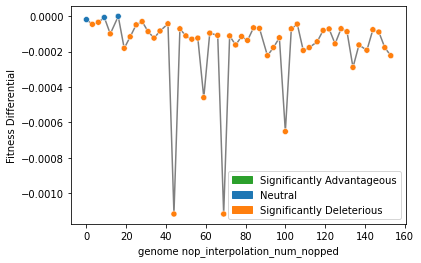

teeplots/bucket=prq49+endeavor=16+hue=set-size+transform=filter-Stint-40+viz=log-lineplot+x=num-sets+y=likelihood+ext=.pdf
teeplots/bucket=prq49+endeavor=16+hue=set-size+transform=filter-Stint-40+viz=log-lineplot+x=num-sets+y=likelihood+ext=.png


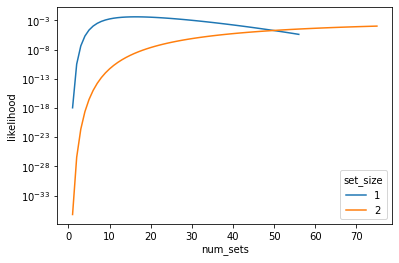

{
    "Series": 16017,
    "a=credible_interval_lower_bound_idx+set_size=1": 8,
    "a=credible_interval_lower_bound_idx+set_size=2": 46,
    "a=credible_interval_upper_bound_idx+set_size=1": 34,
    "a=credible_interval_upper_bound_idx+set_size=2": 75,
    "a=most_credible_idx+set_size=1": 16,
    "a=most_credible_idx+set_size=2": 75,
    "a=most_credible_likelihood+set_size=1": 0.004171728889385781,
    "a=most_credible_likelihood+set_size=2": 0.00010776838197095864,
    "all_nopped_is_less_fit": true,
    "credible_interval_lower_bound_idx": 8,
    "credible_interval_upper_bound_idx": 34,
    "interpolation_complexity": 16,
    "most_credible_idx": 16,
    "most_credible_likelihood": 0.004171728889385781,
    "most_credible_set_size": 1,
    "none_nopped_is_less_fit": false
}


teeplots/bucket=prq49+endeavor=16+hue=relative-fitness+transform=filter-Stint-40+viz=lineplot-scatterplot+x=genome-nop-interpolation-num-nopped+y=fitness-differential+ext=.pdf
teeplots/bucket=prq49+endeavor=16+hue=relative-fitness+transform=filter-Stint-40+viz=lineplot-scatterplot+x=genome-nop-interpolation-num-nopped+y=fitness-differential+ext=.png


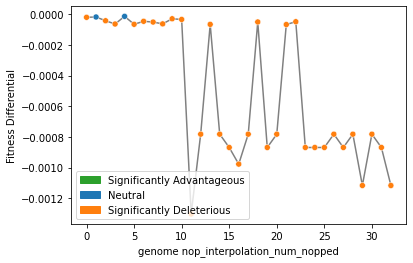

teeplots/bucket=prq49+endeavor=16+hue=set-size+transform=filter-Stint-40+viz=log-lineplot+x=num-sets+y=likelihood+ext=.pdf
teeplots/bucket=prq49+endeavor=16+hue=set-size+transform=filter-Stint-40+viz=log-lineplot+x=num-sets+y=likelihood+ext=.png


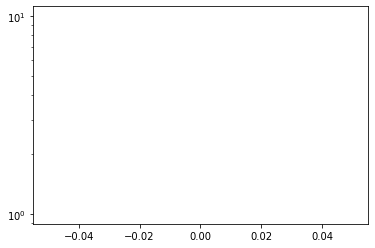

{
    "Series": 16018,
    "all_nopped_is_less_fit": true,
    "credible_interval_lower_bound_idx": NaN,
    "credible_interval_upper_bound_idx": NaN,
    "interpolation_complexity": NaN,
    "most_credible_idx": NaN,
    "most_credible_likelihood": NaN,
    "most_credible_set_size": NaN,
    "none_nopped_is_less_fit": true
}


teeplots/bucket=prq49+endeavor=16+hue=relative-fitness+transform=filter-Stint-40+viz=lineplot-scatterplot+x=genome-nop-interpolation-num-nopped+y=fitness-differential+ext=.pdf
teeplots/bucket=prq49+endeavor=16+hue=relative-fitness+transform=filter-Stint-40+viz=lineplot-scatterplot+x=genome-nop-interpolation-num-nopped+y=fitness-differential+ext=.png


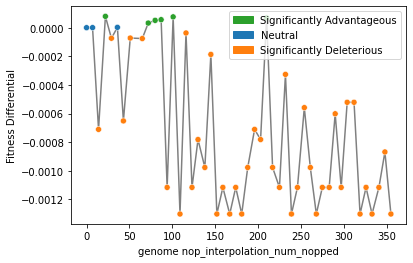

teeplots/bucket=prq49+endeavor=16+hue=set-size+transform=filter-Stint-40+viz=log-lineplot+x=num-sets+y=likelihood+ext=.pdf
teeplots/bucket=prq49+endeavor=16+hue=set-size+transform=filter-Stint-40+viz=log-lineplot+x=num-sets+y=likelihood+ext=.png


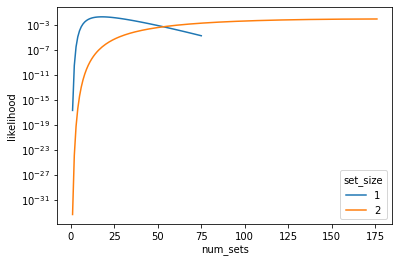

{
    "Series": 16019,
    "a=credible_interval_lower_bound_idx+set_size=1": 8,
    "a=credible_interval_lower_bound_idx+set_size=2": 77,
    "a=credible_interval_upper_bound_idx+set_size=1": 42,
    "a=credible_interval_upper_bound_idx+set_size=2": 176,
    "a=most_credible_idx+set_size=1": 18,
    "a=most_credible_idx+set_size=2": 176,
    "a=most_credible_likelihood+set_size=1": 0.022276081457056878,
    "a=most_credible_likelihood+set_size=2": 0.010093489084384778,
    "all_nopped_is_less_fit": true,
    "credible_interval_lower_bound_idx": 8,
    "credible_interval_upper_bound_idx": 42,
    "interpolation_complexity": 18,
    "most_credible_idx": 18,
    "most_credible_likelihood": 0.022276081457056878,
    "most_credible_set_size": 1,
    "none_nopped_is_less_fit": false
}


teeplots/bucket=prq49+endeavor=16+hue=relative-fitness+transform=filter-Stint-40+viz=lineplot-scatterplot+x=genome-nop-interpolation-num-nopped+y=fitness-differential+ext=.pdf
teeplots/bucket=prq49+endeavor=16+hue=relative-fitness+transform=filter-Stint-40+viz=lineplot-scatterplot+x=genome-nop-interpolation-num-nopped+y=fitness-differential+ext=.png


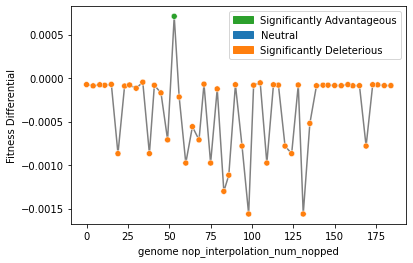

teeplots/bucket=prq49+endeavor=16+hue=set-size+transform=filter-Stint-40+viz=log-lineplot+x=num-sets+y=likelihood+ext=.pdf
teeplots/bucket=prq49+endeavor=16+hue=set-size+transform=filter-Stint-40+viz=log-lineplot+x=num-sets+y=likelihood+ext=.png


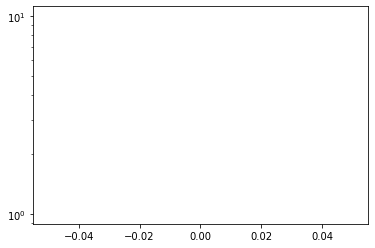

{
    "Series": 16020,
    "all_nopped_is_less_fit": true,
    "credible_interval_lower_bound_idx": NaN,
    "credible_interval_upper_bound_idx": NaN,
    "interpolation_complexity": NaN,
    "most_credible_idx": NaN,
    "most_credible_likelihood": NaN,
    "most_credible_set_size": NaN,
    "none_nopped_is_less_fit": true
}


teeplots/bucket=prq49+endeavor=16+hue=relative-fitness+transform=filter-Stint-40+viz=lineplot-scatterplot+x=genome-nop-interpolation-num-nopped+y=fitness-differential+ext=.pdf
teeplots/bucket=prq49+endeavor=16+hue=relative-fitness+transform=filter-Stint-40+viz=lineplot-scatterplot+x=genome-nop-interpolation-num-nopped+y=fitness-differential+ext=.png


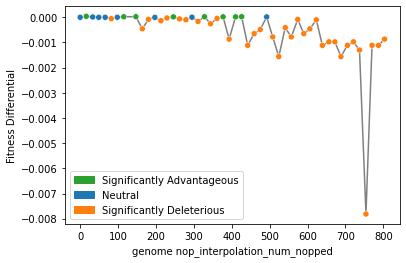

teeplots/bucket=prq49+endeavor=16+hue=set-size+transform=filter-Stint-40+viz=log-lineplot+x=num-sets+y=likelihood+ext=.pdf
teeplots/bucket=prq49+endeavor=16+hue=set-size+transform=filter-Stint-40+viz=log-lineplot+x=num-sets+y=likelihood+ext=.png


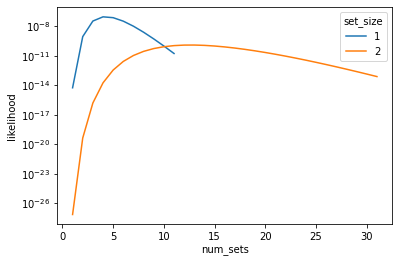

{
    "Series": 16021,
    "a=credible_interval_lower_bound_idx+set_size=1": 3,
    "a=credible_interval_lower_bound_idx+set_size=2": 8,
    "a=credible_interval_upper_bound_idx+set_size=1": 7,
    "a=credible_interval_upper_bound_idx+set_size=2": 21,
    "a=most_credible_idx+set_size=1": 4,
    "a=most_credible_idx+set_size=2": 13,
    "a=most_credible_likelihood+set_size=1": 8.809739148970221e-08,
    "a=most_credible_likelihood+set_size=2": 1.1914446838864555e-10,
    "all_nopped_is_less_fit": true,
    "credible_interval_lower_bound_idx": 3,
    "credible_interval_upper_bound_idx": 7,
    "interpolation_complexity": 4,
    "most_credible_idx": 4,
    "most_credible_likelihood": 8.809739148970221e-08,
    "most_credible_set_size": 1,
    "none_nopped_is_less_fit": false
}


teeplots/bucket=prq49+endeavor=16+hue=relative-fitness+transform=filter-Stint-40+viz=lineplot-scatterplot+x=genome-nop-interpolation-num-nopped+y=fitness-differential+ext=.pdf
teeplots/bucket=prq49+endeavor=16+hue=relative-fitness+transform=filter-Stint-40+viz=lineplot-scatterplot+x=genome-nop-interpolation-num-nopped+y=fitness-differential+ext=.png


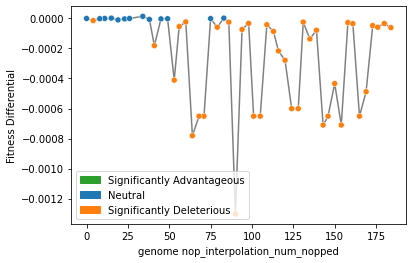

teeplots/bucket=prq49+endeavor=16+hue=set-size+transform=filter-Stint-40+viz=log-lineplot+x=num-sets+y=likelihood+ext=.pdf
teeplots/bucket=prq49+endeavor=16+hue=set-size+transform=filter-Stint-40+viz=log-lineplot+x=num-sets+y=likelihood+ext=.png


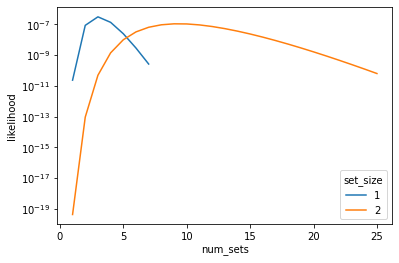

{
    "Series": 16022,
    "a=credible_interval_lower_bound_idx+set_size=1": 2,
    "a=credible_interval_lower_bound_idx+set_size=2": 6,
    "a=credible_interval_upper_bound_idx+set_size=1": 4,
    "a=credible_interval_upper_bound_idx+set_size=2": 16,
    "a=most_credible_idx+set_size=1": 3,
    "a=most_credible_idx+set_size=2": 9,
    "a=most_credible_likelihood+set_size=1": 3.081898855540865e-07,
    "a=most_credible_likelihood+set_size=2": 1.0837775649649986e-07,
    "all_nopped_is_less_fit": true,
    "credible_interval_lower_bound_idx": 2,
    "credible_interval_upper_bound_idx": 4,
    "interpolation_complexity": 3,
    "most_credible_idx": 3,
    "most_credible_likelihood": 3.081898855540865e-07,
    "most_credible_set_size": 1,
    "none_nopped_is_less_fit": false
}


teeplots/bucket=prq49+endeavor=16+hue=relative-fitness+transform=filter-Stint-40+viz=lineplot-scatterplot+x=genome-nop-interpolation-num-nopped+y=fitness-differential+ext=.pdf
teeplots/bucket=prq49+endeavor=16+hue=relative-fitness+transform=filter-Stint-40+viz=lineplot-scatterplot+x=genome-nop-interpolation-num-nopped+y=fitness-differential+ext=.png


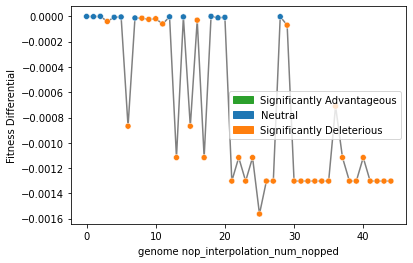

teeplots/bucket=prq49+endeavor=16+hue=set-size+transform=filter-Stint-40+viz=log-lineplot+x=num-sets+y=likelihood+ext=.pdf
teeplots/bucket=prq49+endeavor=16+hue=set-size+transform=filter-Stint-40+viz=log-lineplot+x=num-sets+y=likelihood+ext=.png


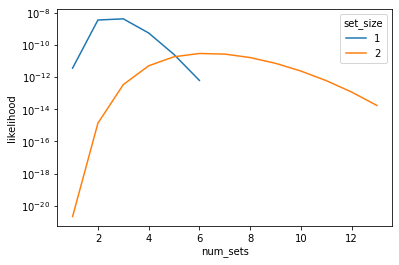

{
    "Series": 16023,
    "a=credible_interval_lower_bound_idx+set_size=1": 2,
    "a=credible_interval_lower_bound_idx+set_size=2": 4,
    "a=credible_interval_upper_bound_idx+set_size=1": 4,
    "a=credible_interval_upper_bound_idx+set_size=2": 9,
    "a=most_credible_idx+set_size=1": 3,
    "a=most_credible_idx+set_size=2": 6,
    "a=most_credible_likelihood+set_size=1": 4.163073932951797e-09,
    "a=most_credible_likelihood+set_size=2": 2.917851795616431e-11,
    "all_nopped_is_less_fit": true,
    "credible_interval_lower_bound_idx": 2,
    "credible_interval_upper_bound_idx": 4,
    "interpolation_complexity": 3,
    "most_credible_idx": 3,
    "most_credible_likelihood": 4.163073932951797e-09,
    "most_credible_set_size": 1,
    "none_nopped_is_less_fit": false
}


teeplots/bucket=prq49+endeavor=16+hue=relative-fitness+transform=filter-Stint-40+viz=lineplot-scatterplot+x=genome-nop-interpolation-num-nopped+y=fitness-differential+ext=.pdf
teeplots/bucket=prq49+endeavor=16+hue=relative-fitness+transform=filter-Stint-40+viz=lineplot-scatterplot+x=genome-nop-interpolation-num-nopped+y=fitness-differential+ext=.png


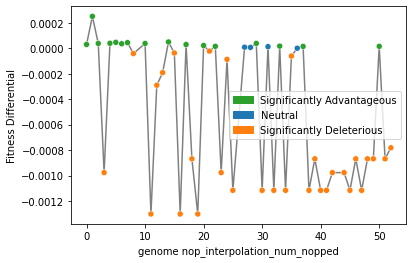

teeplots/bucket=prq49+endeavor=16+hue=set-size+transform=filter-Stint-40+viz=log-lineplot+x=num-sets+y=likelihood+ext=.pdf
teeplots/bucket=prq49+endeavor=16+hue=set-size+transform=filter-Stint-40+viz=lineplot+x=num-sets+y=likelihood+ext=.pdf
teeplots/bucket=prq49+endeavor=16+hue=set-size+transform=filter-Stint-40+viz=lineplot+x=num-sets+y=likelihood+ext=.png


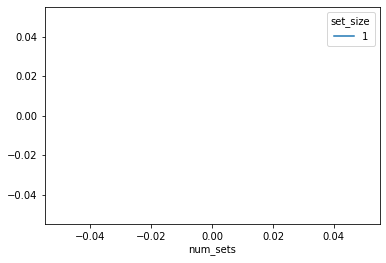

{
    "Series": 16024,
    "a=credible_interval_lower_bound_idx+set_size=1": NaN,
    "a=credible_interval_upper_bound_idx+set_size=1": NaN,
    "a=most_credible_idx+set_size=1": NaN,
    "a=most_credible_likelihood+set_size=1": NaN,
    "all_nopped_is_less_fit": true,
    "credible_interval_lower_bound_idx": NaN,
    "credible_interval_upper_bound_idx": NaN,
    "interpolation_complexity": NaN,
    "most_credible_idx": NaN,
    "most_credible_likelihood": NaN,
    "most_credible_set_size": 1,
    "none_nopped_is_less_fit": false
}


teeplots/bucket=prq49+endeavor=16+hue=relative-fitness+transform=filter-Stint-40+viz=lineplot-scatterplot+x=genome-nop-interpolation-num-nopped+y=fitness-differential+ext=.pdf
teeplots/bucket=prq49+endeavor=16+hue=relative-fitness+transform=filter-Stint-40+viz=lineplot-scatterplot+x=genome-nop-interpolation-num-nopped+y=fitness-differential+ext=.png


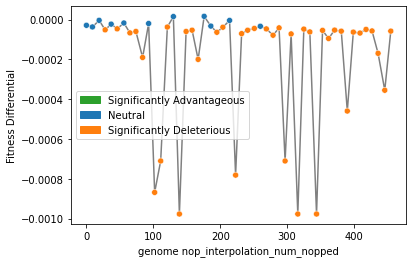

teeplots/bucket=prq49+endeavor=16+hue=set-size+transform=filter-Stint-40+viz=log-lineplot+x=num-sets+y=likelihood+ext=.pdf
teeplots/bucket=prq49+endeavor=16+hue=set-size+transform=filter-Stint-40+viz=log-lineplot+x=num-sets+y=likelihood+ext=.png


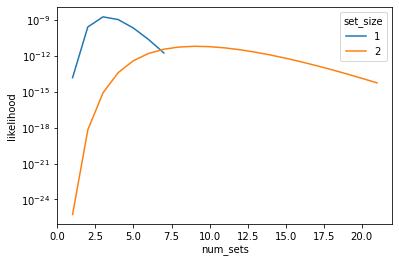

{
    "Series": 16025,
    "a=credible_interval_lower_bound_idx+set_size=1": 2,
    "a=credible_interval_lower_bound_idx+set_size=2": 6,
    "a=credible_interval_upper_bound_idx+set_size=1": 5,
    "a=credible_interval_upper_bound_idx+set_size=2": 14,
    "a=most_credible_idx+set_size=1": 3,
    "a=most_credible_idx+set_size=2": 9,
    "a=most_credible_likelihood+set_size=1": 1.9372336671340793e-09,
    "a=most_credible_likelihood+set_size=2": 6.610878760245154e-12,
    "all_nopped_is_less_fit": true,
    "credible_interval_lower_bound_idx": 2,
    "credible_interval_upper_bound_idx": 5,
    "interpolation_complexity": 3,
    "most_credible_idx": 3,
    "most_credible_likelihood": 1.9372336671340793e-09,
    "most_credible_set_size": 1,
    "none_nopped_is_less_fit": false
}


teeplots/bucket=prq49+endeavor=16+hue=relative-fitness+transform=filter-Stint-40+viz=lineplot-scatterplot+x=genome-nop-interpolation-num-nopped+y=fitness-differential+ext=.pdf
teeplots/bucket=prq49+endeavor=16+hue=relative-fitness+transform=filter-Stint-40+viz=lineplot-scatterplot+x=genome-nop-interpolation-num-nopped+y=fitness-differential+ext=.png


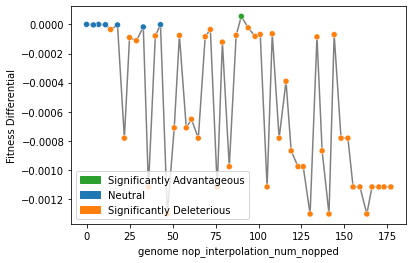

teeplots/bucket=prq49+endeavor=16+hue=set-size+transform=filter-Stint-40+viz=log-lineplot+x=num-sets+y=likelihood+ext=.pdf
teeplots/bucket=prq49+endeavor=16+hue=set-size+transform=filter-Stint-40+viz=log-lineplot+x=num-sets+y=likelihood+ext=.png


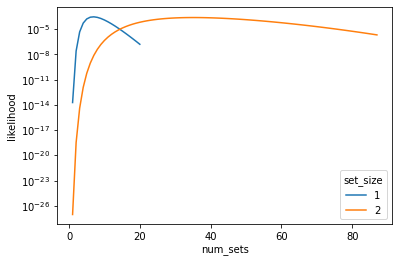

{
    "Series": 16026,
    "a=credible_interval_lower_bound_idx+set_size=1": 4,
    "a=credible_interval_lower_bound_idx+set_size=2": 18,
    "a=credible_interval_upper_bound_idx+set_size=1": 12,
    "a=credible_interval_upper_bound_idx+set_size=2": 65,
    "a=most_credible_idx+set_size=1": 7,
    "a=most_credible_idx+set_size=2": 35,
    "a=most_credible_likelihood+set_size=1": 0.00029496536593592545,
    "a=most_credible_likelihood+set_size=2": 0.00024326081469768182,
    "all_nopped_is_less_fit": true,
    "credible_interval_lower_bound_idx": 4,
    "credible_interval_upper_bound_idx": 12,
    "interpolation_complexity": 7,
    "most_credible_idx": 7,
    "most_credible_likelihood": 0.00029496536593592545,
    "most_credible_set_size": 1,
    "none_nopped_is_less_fit": false
}


teeplots/bucket=prq49+endeavor=16+hue=relative-fitness+transform=filter-Stint-40+viz=lineplot-scatterplot+x=genome-nop-interpolation-num-nopped+y=fitness-differential+ext=.pdf
teeplots/bucket=prq49+endeavor=16+hue=relative-fitness+transform=filter-Stint-40+viz=lineplot-scatterplot+x=genome-nop-interpolation-num-nopped+y=fitness-differential+ext=.png


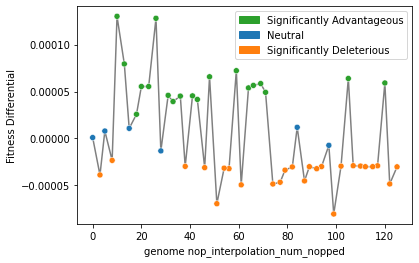

teeplots/bucket=prq49+endeavor=16+hue=set-size+transform=filter-Stint-40+viz=log-lineplot+x=num-sets+y=likelihood+ext=.pdf
teeplots/bucket=prq49+endeavor=16+hue=set-size+transform=filter-Stint-40+viz=log-lineplot+x=num-sets+y=likelihood+ext=.png


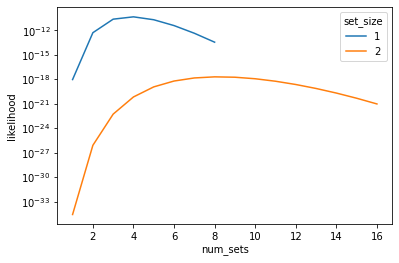

{
    "Series": 16027,
    "a=credible_interval_lower_bound_idx+set_size=1": 3,
    "a=credible_interval_lower_bound_idx+set_size=2": 6,
    "a=credible_interval_upper_bound_idx+set_size=1": 6,
    "a=credible_interval_upper_bound_idx+set_size=2": 12,
    "a=most_credible_idx+set_size=1": 4,
    "a=most_credible_idx+set_size=2": 8,
    "a=most_credible_likelihood+set_size=1": 4.671064647304225e-11,
    "a=most_credible_likelihood+set_size=2": 2.0092125021260122e-18,
    "all_nopped_is_less_fit": true,
    "credible_interval_lower_bound_idx": 3,
    "credible_interval_upper_bound_idx": 6,
    "interpolation_complexity": 4,
    "most_credible_idx": 4,
    "most_credible_likelihood": 4.671064647304225e-11,
    "most_credible_set_size": 1,
    "none_nopped_is_less_fit": false
}


teeplots/bucket=prq49+endeavor=16+hue=relative-fitness+transform=filter-Stint-40+viz=lineplot-scatterplot+x=genome-nop-interpolation-num-nopped+y=fitness-differential+ext=.pdf
teeplots/bucket=prq49+endeavor=16+hue=relative-fitness+transform=filter-Stint-40+viz=lineplot-scatterplot+x=genome-nop-interpolation-num-nopped+y=fitness-differential+ext=.png


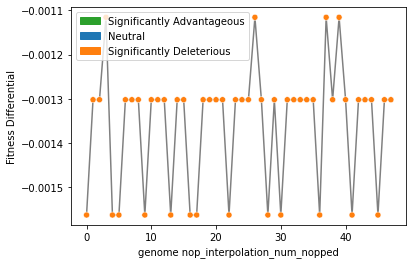

teeplots/bucket=prq49+endeavor=16+hue=set-size+transform=filter-Stint-40+viz=log-lineplot+x=num-sets+y=likelihood+ext=.pdf
teeplots/bucket=prq49+endeavor=16+hue=set-size+transform=filter-Stint-40+viz=log-lineplot+x=num-sets+y=likelihood+ext=.png


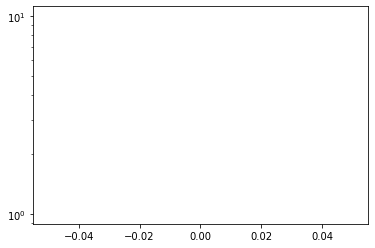

{
    "Series": 16028,
    "all_nopped_is_less_fit": true,
    "credible_interval_lower_bound_idx": NaN,
    "credible_interval_upper_bound_idx": NaN,
    "interpolation_complexity": NaN,
    "most_credible_idx": NaN,
    "most_credible_likelihood": NaN,
    "most_credible_set_size": NaN,
    "none_nopped_is_less_fit": true
}


teeplots/bucket=prq49+endeavor=16+hue=relative-fitness+transform=filter-Stint-40+viz=lineplot-scatterplot+x=genome-nop-interpolation-num-nopped+y=fitness-differential+ext=.pdf
teeplots/bucket=prq49+endeavor=16+hue=relative-fitness+transform=filter-Stint-40+viz=lineplot-scatterplot+x=genome-nop-interpolation-num-nopped+y=fitness-differential+ext=.png


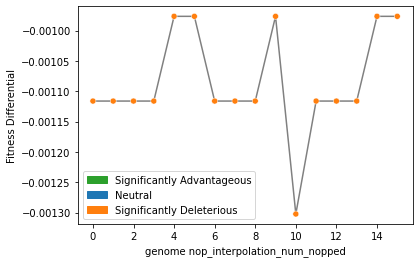

teeplots/bucket=prq49+endeavor=16+hue=set-size+transform=filter-Stint-40+viz=log-lineplot+x=num-sets+y=likelihood+ext=.pdf
teeplots/bucket=prq49+endeavor=16+hue=set-size+transform=filter-Stint-40+viz=log-lineplot+x=num-sets+y=likelihood+ext=.png


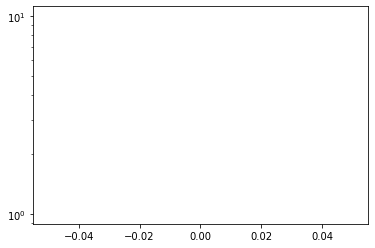

{
    "Series": 16029,
    "all_nopped_is_less_fit": true,
    "credible_interval_lower_bound_idx": NaN,
    "credible_interval_upper_bound_idx": NaN,
    "interpolation_complexity": NaN,
    "most_credible_idx": NaN,
    "most_credible_likelihood": NaN,
    "most_credible_set_size": NaN,
    "none_nopped_is_less_fit": true
}


teeplots/bucket=prq49+endeavor=16+hue=relative-fitness+transform=filter-Stint-40+viz=lineplot-scatterplot+x=genome-nop-interpolation-num-nopped+y=fitness-differential+ext=.pdf
teeplots/bucket=prq49+endeavor=16+hue=relative-fitness+transform=filter-Stint-40+viz=lineplot-scatterplot+x=genome-nop-interpolation-num-nopped+y=fitness-differential+ext=.png


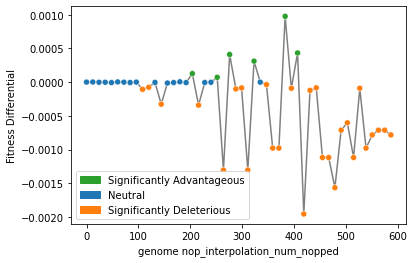

teeplots/bucket=prq49+endeavor=16+hue=set-size+transform=filter-Stint-40+viz=log-lineplot+x=num-sets+y=likelihood+ext=.pdf
teeplots/bucket=prq49+endeavor=16+hue=set-size+transform=filter-Stint-40+viz=log-lineplot+x=num-sets+y=likelihood+ext=.png


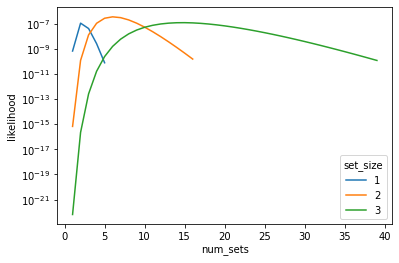

{
    "Series": 16030,
    "a=credible_interval_lower_bound_idx+set_size=1": 2,
    "a=credible_interval_lower_bound_idx+set_size=2": 4,
    "a=credible_interval_lower_bound_idx+set_size=3": 8,
    "a=credible_interval_upper_bound_idx+set_size=1": 3,
    "a=credible_interval_upper_bound_idx+set_size=2": 10,
    "a=credible_interval_upper_bound_idx+set_size=3": 25,
    "a=most_credible_idx+set_size=1": 2,
    "a=most_credible_idx+set_size=2": 6,
    "a=most_credible_idx+set_size=3": 15,
    "a=most_credible_likelihood+set_size=1": 1.0989128531926858e-07,
    "a=most_credible_likelihood+set_size=2": 3.501721752974872e-07,
    "a=most_credible_likelihood+set_size=3": 1.2031807643229567e-07,
    "all_nopped_is_less_fit": true,
    "credible_interval_lower_bound_idx": 4,
    "credible_interval_upper_bound_idx": 10,
    "interpolation_complexity": 6,
    "most_credible_idx": 6,
    "most_credible_likelihood": 3.501721752974872e-07,
    "most_credible_set_size": 2,
    "none_nopped_is_less_fi

teeplots/bucket=prq49+endeavor=16+hue=relative-fitness+transform=filter-Stint-40+viz=lineplot-scatterplot+x=genome-nop-interpolation-num-nopped+y=fitness-differential+ext=.pdf
teeplots/bucket=prq49+endeavor=16+hue=relative-fitness+transform=filter-Stint-40+viz=lineplot-scatterplot+x=genome-nop-interpolation-num-nopped+y=fitness-differential+ext=.png


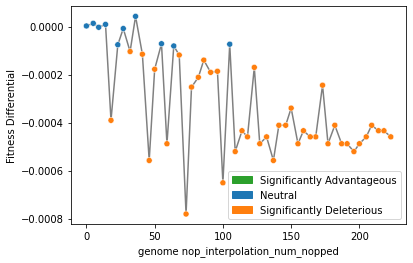

teeplots/bucket=prq49+endeavor=16+hue=set-size+transform=filter-Stint-40+viz=log-lineplot+x=num-sets+y=likelihood+ext=.pdf
teeplots/bucket=prq49+endeavor=16+hue=set-size+transform=filter-Stint-40+viz=log-lineplot+x=num-sets+y=likelihood+ext=.png


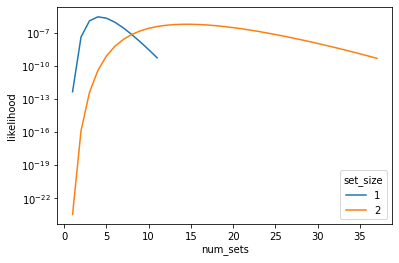

{
    "Series": 16031,
    "a=credible_interval_lower_bound_idx+set_size=1": 3,
    "a=credible_interval_lower_bound_idx+set_size=2": 8,
    "a=credible_interval_upper_bound_idx+set_size=1": 7,
    "a=credible_interval_upper_bound_idx+set_size=2": 24,
    "a=most_credible_idx+set_size=1": 4,
    "a=most_credible_idx+set_size=2": 15,
    "a=most_credible_likelihood+set_size=1": 2.6124970701570574e-06,
    "a=most_credible_likelihood+set_size=2": 5.568296723722123e-07,
    "all_nopped_is_less_fit": true,
    "credible_interval_lower_bound_idx": 3,
    "credible_interval_upper_bound_idx": 7,
    "interpolation_complexity": 4,
    "most_credible_idx": 4,
    "most_credible_likelihood": 2.6124970701570574e-06,
    "most_credible_set_size": 1,
    "none_nopped_is_less_fit": false
}


teeplots/bucket=prq49+endeavor=16+hue=relative-fitness+transform=filter-Stint-40+viz=lineplot-scatterplot+x=genome-nop-interpolation-num-nopped+y=fitness-differential+ext=.pdf
teeplots/bucket=prq49+endeavor=16+hue=relative-fitness+transform=filter-Stint-40+viz=lineplot-scatterplot+x=genome-nop-interpolation-num-nopped+y=fitness-differential+ext=.png


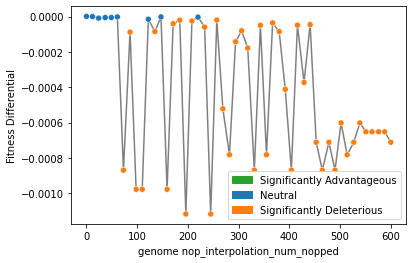

teeplots/bucket=prq49+endeavor=16+hue=set-size+transform=filter-Stint-40+viz=log-lineplot+x=num-sets+y=likelihood+ext=.pdf
teeplots/bucket=prq49+endeavor=16+hue=set-size+transform=filter-Stint-40+viz=log-lineplot+x=num-sets+y=likelihood+ext=.png


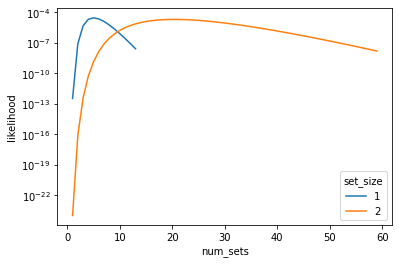

{
    "Series": 16032,
    "a=credible_interval_lower_bound_idx+set_size=1": 3,
    "a=credible_interval_lower_bound_idx+set_size=2": 11,
    "a=credible_interval_upper_bound_idx+set_size=1": 8,
    "a=credible_interval_upper_bound_idx+set_size=2": 37,
    "a=most_credible_idx+set_size=1": 5,
    "a=most_credible_idx+set_size=2": 20,
    "a=most_credible_likelihood+set_size=1": 2.864474067603515e-05,
    "a=most_credible_likelihood+set_size=2": 2.00109530179764e-05,
    "all_nopped_is_less_fit": true,
    "credible_interval_lower_bound_idx": 3,
    "credible_interval_upper_bound_idx": 8,
    "interpolation_complexity": 5,
    "most_credible_idx": 5,
    "most_credible_likelihood": 2.864474067603515e-05,
    "most_credible_set_size": 1,
    "none_nopped_is_less_fit": false
}


teeplots/bucket=prq49+endeavor=16+hue=relative-fitness+transform=filter-Stint-40+viz=lineplot-scatterplot+x=genome-nop-interpolation-num-nopped+y=fitness-differential+ext=.pdf
teeplots/bucket=prq49+endeavor=16+hue=relative-fitness+transform=filter-Stint-40+viz=lineplot-scatterplot+x=genome-nop-interpolation-num-nopped+y=fitness-differential+ext=.png


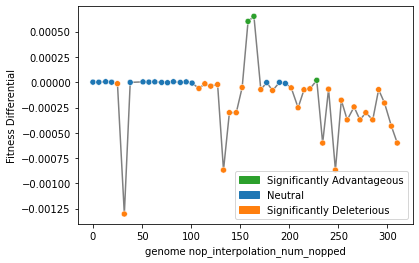

teeplots/bucket=prq49+endeavor=16+hue=set-size+transform=filter-Stint-40+viz=log-lineplot+x=num-sets+y=likelihood+ext=.pdf
teeplots/bucket=prq49+endeavor=16+hue=set-size+transform=filter-Stint-40+viz=log-lineplot+x=num-sets+y=likelihood+ext=.png


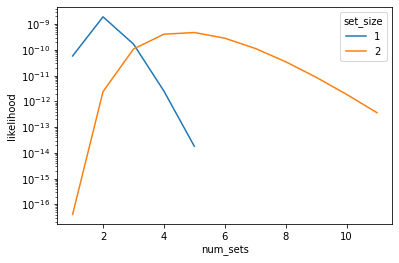

{
    "Series": 16033,
    "a=credible_interval_lower_bound_idx+set_size=1": 2,
    "a=credible_interval_lower_bound_idx+set_size=2": 3,
    "a=credible_interval_upper_bound_idx+set_size=1": 3,
    "a=credible_interval_upper_bound_idx+set_size=2": 7,
    "a=most_credible_idx+set_size=1": 2,
    "a=most_credible_idx+set_size=2": 5,
    "a=most_credible_likelihood+set_size=1": 1.916169466895238e-09,
    "a=most_credible_likelihood+set_size=2": 4.718157828773317e-10,
    "all_nopped_is_less_fit": true,
    "credible_interval_lower_bound_idx": 2,
    "credible_interval_upper_bound_idx": 3,
    "interpolation_complexity": 2,
    "most_credible_idx": 2,
    "most_credible_likelihood": 1.916169466895238e-09,
    "most_credible_set_size": 1,
    "none_nopped_is_less_fit": false
}


teeplots/bucket=prq49+endeavor=16+hue=relative-fitness+transform=filter-Stint-40+viz=lineplot-scatterplot+x=genome-nop-interpolation-num-nopped+y=fitness-differential+ext=.pdf
teeplots/bucket=prq49+endeavor=16+hue=relative-fitness+transform=filter-Stint-40+viz=lineplot-scatterplot+x=genome-nop-interpolation-num-nopped+y=fitness-differential+ext=.png


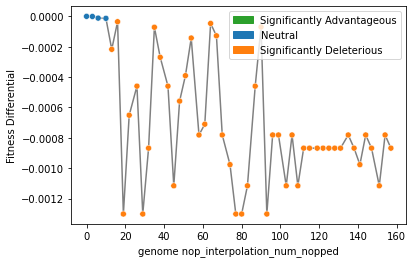

teeplots/bucket=prq49+endeavor=16+hue=set-size+transform=filter-Stint-40+viz=log-lineplot+x=num-sets+y=likelihood+ext=.pdf
teeplots/bucket=prq49+endeavor=16+hue=set-size+transform=filter-Stint-40+viz=log-lineplot+x=num-sets+y=likelihood+ext=.png


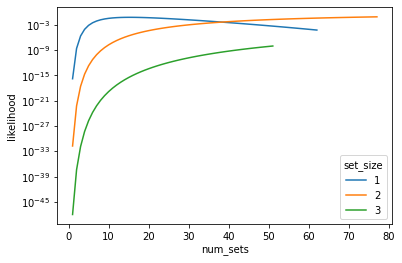

{
    "Series": 16034,
    "a=credible_interval_lower_bound_idx+set_size=1": 7,
    "a=credible_interval_lower_bound_idx+set_size=2": 45,
    "a=credible_interval_lower_bound_idx+set_size=3": 41,
    "a=credible_interval_upper_bound_idx+set_size=1": 35,
    "a=credible_interval_upper_bound_idx+set_size=2": 77,
    "a=credible_interval_upper_bound_idx+set_size=3": 51,
    "a=most_credible_idx+set_size=1": 15,
    "a=most_credible_idx+set_size=2": 77,
    "a=most_credible_idx+set_size=3": 51,
    "a=most_credible_likelihood+set_size=1": 0.05687973403565211,
    "a=most_credible_likelihood+set_size=2": 0.07375278382808442,
    "a=most_credible_likelihood+set_size=3": 9.004122289435617e-09,
    "all_nopped_is_less_fit": true,
    "credible_interval_lower_bound_idx": 45,
    "credible_interval_upper_bound_idx": 77,
    "interpolation_complexity": 77,
    "most_credible_idx": 77,
    "most_credible_likelihood": 0.07375278382808442,
    "most_credible_set_size": 2,
    "none_nopped_is_less_fi

teeplots/bucket=prq49+endeavor=16+hue=relative-fitness+transform=filter-Stint-40+viz=lineplot-scatterplot+x=genome-nop-interpolation-num-nopped+y=fitness-differential+ext=.pdf
teeplots/bucket=prq49+endeavor=16+hue=relative-fitness+transform=filter-Stint-40+viz=lineplot-scatterplot+x=genome-nop-interpolation-num-nopped+y=fitness-differential+ext=.png


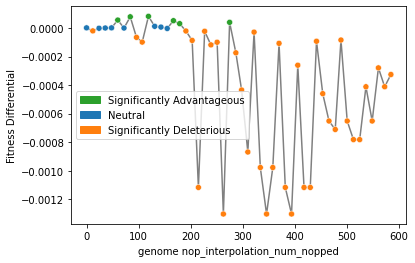

teeplots/bucket=prq49+endeavor=16+hue=set-size+transform=filter-Stint-40+viz=log-lineplot+x=num-sets+y=likelihood+ext=.pdf
teeplots/bucket=prq49+endeavor=16+hue=set-size+transform=filter-Stint-40+viz=log-lineplot+x=num-sets+y=likelihood+ext=.png


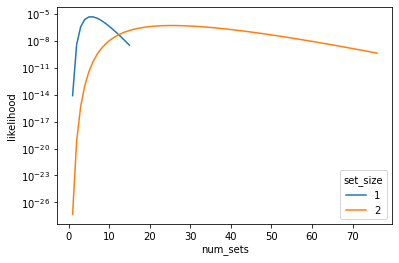

{
    "Series": 16035,
    "a=credible_interval_lower_bound_idx+set_size=1": 4,
    "a=credible_interval_lower_bound_idx+set_size=2": 13,
    "a=credible_interval_upper_bound_idx+set_size=1": 10,
    "a=credible_interval_upper_bound_idx+set_size=2": 47,
    "a=most_credible_idx+set_size=1": 6,
    "a=most_credible_idx+set_size=2": 26,
    "a=most_credible_likelihood+set_size=1": 5.0150391068852846e-06,
    "a=most_credible_likelihood+set_size=2": 5.372527961219357e-07,
    "all_nopped_is_less_fit": true,
    "credible_interval_lower_bound_idx": 4,
    "credible_interval_upper_bound_idx": 10,
    "interpolation_complexity": 6,
    "most_credible_idx": 6,
    "most_credible_likelihood": 5.0150391068852846e-06,
    "most_credible_set_size": 1,
    "none_nopped_is_less_fit": false
}


teeplots/bucket=prq49+endeavor=16+hue=relative-fitness+transform=filter-Stint-40+viz=lineplot-scatterplot+x=genome-nop-interpolation-num-nopped+y=fitness-differential+ext=.pdf
teeplots/bucket=prq49+endeavor=16+hue=relative-fitness+transform=filter-Stint-40+viz=lineplot-scatterplot+x=genome-nop-interpolation-num-nopped+y=fitness-differential+ext=.png


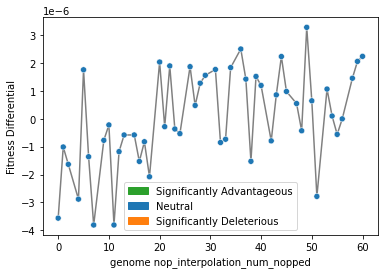

teeplots/bucket=prq49+endeavor=16+hue=set-size+transform=filter-Stint-40+viz=log-lineplot+x=num-sets+y=likelihood+ext=.pdf
teeplots/bucket=prq49+endeavor=16+hue=set-size+transform=filter-Stint-40+viz=log-lineplot+x=num-sets+y=likelihood+ext=.png


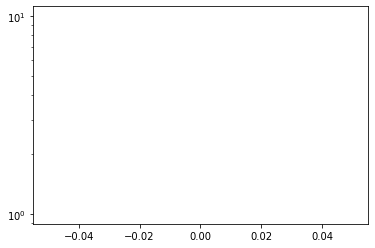

{
    "Series": 16036,
    "all_nopped_is_less_fit": false,
    "credible_interval_lower_bound_idx": NaN,
    "credible_interval_upper_bound_idx": NaN,
    "interpolation_complexity": NaN,
    "most_credible_idx": NaN,
    "most_credible_likelihood": NaN,
    "most_credible_set_size": NaN,
    "none_nopped_is_less_fit": false
}


teeplots/bucket=prq49+endeavor=16+hue=relative-fitness+transform=filter-Stint-40+viz=lineplot-scatterplot+x=genome-nop-interpolation-num-nopped+y=fitness-differential+ext=.pdf
teeplots/bucket=prq49+endeavor=16+hue=relative-fitness+transform=filter-Stint-40+viz=lineplot-scatterplot+x=genome-nop-interpolation-num-nopped+y=fitness-differential+ext=.png


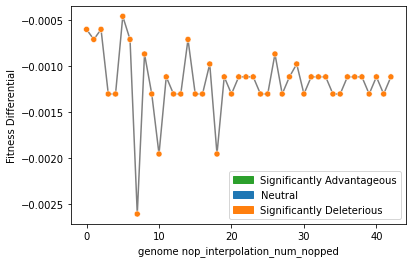

teeplots/bucket=prq49+endeavor=16+hue=set-size+transform=filter-Stint-40+viz=log-lineplot+x=num-sets+y=likelihood+ext=.pdf
teeplots/bucket=prq49+endeavor=16+hue=set-size+transform=filter-Stint-40+viz=log-lineplot+x=num-sets+y=likelihood+ext=.png


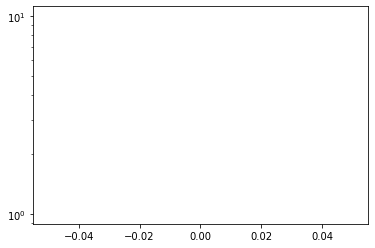

{
    "Series": 16037,
    "all_nopped_is_less_fit": true,
    "credible_interval_lower_bound_idx": NaN,
    "credible_interval_upper_bound_idx": NaN,
    "interpolation_complexity": NaN,
    "most_credible_idx": NaN,
    "most_credible_likelihood": NaN,
    "most_credible_set_size": NaN,
    "none_nopped_is_less_fit": true
}


teeplots/bucket=prq49+endeavor=16+hue=relative-fitness+transform=filter-Stint-40+viz=lineplot-scatterplot+x=genome-nop-interpolation-num-nopped+y=fitness-differential+ext=.pdf
teeplots/bucket=prq49+endeavor=16+hue=relative-fitness+transform=filter-Stint-40+viz=lineplot-scatterplot+x=genome-nop-interpolation-num-nopped+y=fitness-differential+ext=.png


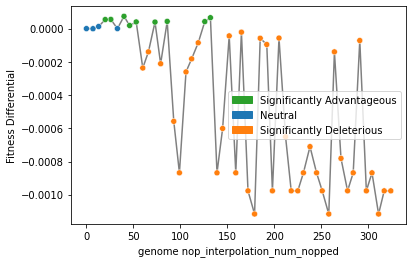

teeplots/bucket=prq49+endeavor=16+hue=set-size+transform=filter-Stint-40+viz=log-lineplot+x=num-sets+y=likelihood+ext=.pdf
teeplots/bucket=prq49+endeavor=16+hue=set-size+transform=filter-Stint-40+viz=log-lineplot+x=num-sets+y=likelihood+ext=.png


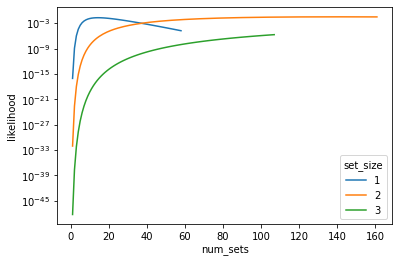

{
    "Series": 16038,
    "a=credible_interval_lower_bound_idx+set_size=1": 7,
    "a=credible_interval_lower_bound_idx+set_size=2": 65,
    "a=credible_interval_lower_bound_idx+set_size=3": 79,
    "a=credible_interval_upper_bound_idx+set_size=1": 32,
    "a=credible_interval_upper_bound_idx+set_size=2": 161,
    "a=credible_interval_upper_bound_idx+set_size=3": 107,
    "a=most_credible_idx+set_size=1": 14,
    "a=most_credible_idx+set_size=2": 141,
    "a=most_credible_idx+set_size=3": 107,
    "a=most_credible_likelihood+set_size=1": 0.021388170651723448,
    "a=most_credible_likelihood+set_size=2": 0.034617618092738535,
    "a=most_credible_likelihood+set_size=3": 2.0851739750702805e-06,
    "all_nopped_is_less_fit": true,
    "credible_interval_lower_bound_idx": 65,
    "credible_interval_upper_bound_idx": 161,
    "interpolation_complexity": 141,
    "most_credible_idx": 141,
    "most_credible_likelihood": 0.034617618092738535,
    "most_credible_set_size": 2,
    "none_nopped

teeplots/bucket=prq49+endeavor=16+hue=relative-fitness+transform=filter-Stint-40+viz=lineplot-scatterplot+x=genome-nop-interpolation-num-nopped+y=fitness-differential+ext=.pdf
teeplots/bucket=prq49+endeavor=16+hue=relative-fitness+transform=filter-Stint-40+viz=lineplot-scatterplot+x=genome-nop-interpolation-num-nopped+y=fitness-differential+ext=.png


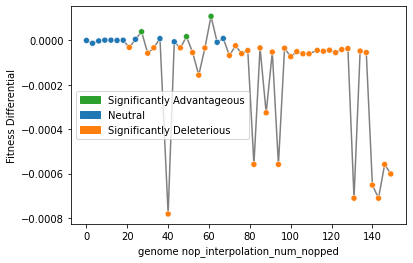

teeplots/bucket=prq49+endeavor=16+hue=set-size+transform=filter-Stint-40+viz=log-lineplot+x=num-sets+y=likelihood+ext=.pdf
teeplots/bucket=prq49+endeavor=16+hue=set-size+transform=filter-Stint-40+viz=log-lineplot+x=num-sets+y=likelihood+ext=.png


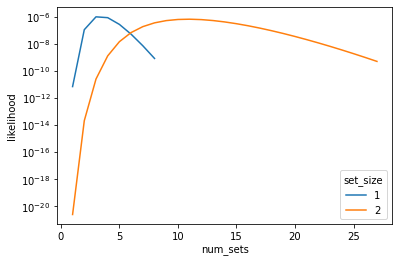

{
    "Series": 16039,
    "a=credible_interval_lower_bound_idx+set_size=1": 2,
    "a=credible_interval_lower_bound_idx+set_size=2": 7,
    "a=credible_interval_upper_bound_idx+set_size=1": 5,
    "a=credible_interval_upper_bound_idx+set_size=2": 18,
    "a=most_credible_idx+set_size=1": 3,
    "a=most_credible_idx+set_size=2": 11,
    "a=most_credible_likelihood+set_size=1": 1.045577153012517e-06,
    "a=most_credible_likelihood+set_size=2": 6.986458325608786e-07,
    "all_nopped_is_less_fit": true,
    "credible_interval_lower_bound_idx": 2,
    "credible_interval_upper_bound_idx": 5,
    "interpolation_complexity": 3,
    "most_credible_idx": 3,
    "most_credible_likelihood": 1.045577153012517e-06,
    "most_credible_set_size": 1,
    "none_nopped_is_less_fit": false
}


In [9]:
# display(HTML("<style>div.output_scroll { height: 1000em; }</style>"))

for series in df['genome series'].unique():

    display(HTML(f'<h1>series {series}</h1>'))


    display(HTML('<h2>interpolation competition</h2>'))
    tp.tee(
        lineplot_scatterplot,
        x='genome nop_interpolation_num_nopped',
        y='Fitness Differential',
        hue='Relative Fitness',
        data=df[df['genome series'] == series].dropna(subset=['genome nop_interpolation_num_nopped']),
        teeplot_outattrs={
            'bucket' : ib.dub( df['Treatment bucket'] ),
            'endeavor' : ib.dub( df['Competition Endeavor'] ),
            'transform' : 'filter-Stint-40',
            '_context' : get_env_context(),
            '_dfdigest' : dfdigest,
            '_revision' : get_git_revision_hash(),
            '_timestamp' : make_timestamp(),
        },
    )
    plt.show()



    display(HTML('<h2>num_sets fitting</h2>'))
    def tee(plotter):
        tp.tee(
            plotter,
            x='num_sets',
            y='likelihood',
            hue='set_size',
            data=calc_loglikelihoods_over_set_sizes(
                series=series,
                interpolation_competitions_df=df,
            ).astype({
                # so seaborn will color as categorical, not quantitative
                'set_size': 'str',
            }),
            teeplot_outattrs={
                'bucket' : ib.dub( df['Treatment bucket'] ),
                'endeavor' : ib.dub( df['Competition Endeavor'] ),
                'transform' : 'filter-Stint-40',
                '_context' : get_env_context(),
                '_dfdigest' : dfdigest,
                '_revision' : get_git_revision_hash(),
                '_timestamp' : make_timestamp(),
            },
        )

    try:
        tee(log_lineplot)
    except ValueError:
        plt.clf()
        tee(sns.lineplot)
    plt.show()

    display(HTML('<h2>model fit results</h2>'))
    print(json.dumps(
        estimate_interpolation_complexity(
            series=series,
            interpolation_competitions_df=df,
        ),
        sort_keys=True,
        indent=4,
        cls=NumpyEncoder,
    ))